In [2]:
from platform import python_version

print(python_version())

3.7.4


In [3]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-10-01 00:00:05+00:00
2019-10-01 08:00:05+08:00


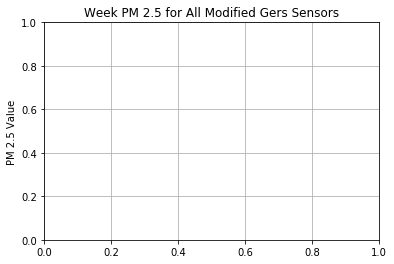

In [4]:
# all_modified_gers - This is the working boxplot for all_modified_gers only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

# Don't include sensors: FL, IA, KS, MB, NB, NJ, NL, OR, WA, WY
# Look more closely at: NE, NS

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
print(data.index[1])
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']

# Clean up data this way:
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
data['pm2_5'] = data['pm2_5'] / (1 + ((0.4/1.65)/(-1+(1/(35/100)))))
# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']

# start clean up data mode when in office or switched from outdoor to indoor or vice versa

# -------------------------- In Office ----------------------------------------------------------------------------------------------------------------------------
ak = data[data.index < '2020-02-15'].groupby("name").get_group('AK')
co = data[data.index < '2020-02-15'].groupby("name").get_group('CO')
ky = data[data.index < '2020-02-15'].groupby("name").get_group('KY')

# mb = data[data.index < '2020-02-15'].groupby("name").get_group('MB')
# mb = mb[(mb.index < '2020-01-26') | (mb.index >= '2020-02-04')]

# nj = data[(data.index < '2020-01-28') | (data.index >= '2020-02-04')].groupby("name").get_group('NJ')
nu = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('NU')
# oregon = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('OR')
pe = data[(data.index < '2020-02-11')].groupby("name").get_group('PE') #outdoor sensor we are no longer using these sensors data
# wy = data[(data.index < '2020-02-11')].groupby("name").get_group('WY') 

# --------------------------------------- Switched ---------------------------------------------------------------------------------------------------------------

ab = data[(data.index > '2020-01-28') & (data.index <= '2020-02-14')].groupby("name").get_group('AB') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ns = data[(data.index >= '2020-01-28')].groupby("name").get_group('NS') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
# oregon = oregon[(oregon.index >= '2020-01-28')] # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ut = data[(data.index >= '2020-01-29')].groupby("name").get_group('UT') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor

# finish clean up data mode when in office or switched from outdoor to indoor or vice versa
# ------------------------------------------------------------------------------------------------------------------------------------------------------

modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'ID', 'IL', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM', 'GA', 'ND', 'NE']
modified_gers_data = data[(data.name == modified_gers[0]) | (data.name == modified_gers[1]) | (data.name == modified_gers[2]) | (data.name == modified_gers[3]) | (data.name == modified_gers[4]) | (data.name == modified_gers[5]) | (data.name == modified_gers[6]) | (data.name == modified_gers[7]) | (data.name == modified_gers[8]) | (data.name == modified_gers[9]) | (data.name == modified_gers[10]) | (data.name == modified_gers[11]) | (data.name == modified_gers[12]) | (data.name == modified_gers[13]) | (data.name == modified_gers[14]) | (data.name == modified_gers[15]) | (data.name == modified_gers[16]) | (data.name == modified_gers[17]) | (data.name == modified_gers[18]) | (data.name == modified_gers[19]) | (data.name == modified_gers[20]) | (data.name == modified_gers[21])]
modified_gers_data = modified_gers_data.append(ak)
modified_gers_data = modified_gers_data.append(co)
modified_gers_data = modified_gers_data.append(ky)
# unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
# unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

unmodified_gers = ['OK', 'PA', 'RI', 'SD', 'VA', 'WI']
unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5])]
unmodified_gers_data = unmodified_gers_data.append(ab)
# unmodified_gers_data = unmodified_gers_data.append(mb)
# unmodified_gers_data = unmodified_gers_data.append(nj)
unmodified_gers_data = unmodified_gers_data.append(nu)
unmodified_gers_data = unmodified_gers_data.append(ns)
# unmodified_gers_data = unmodified_gers_data.append(oregon)
unmodified_gers_data = unmodified_gers_data.append(ut)


All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'ID', 'IL', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday',
       ...
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday'],
      dtype='object', length=1000)
All Modified Gers list size: 7071651
whiskers:  [0.0, 334.3546391752577]
caps:  [0.0, 334.3546391752577]
boxes:  [14.152577319587628]
medians:  [41.57319587628866]
means:  [95.79920162925251]
fliers:  []


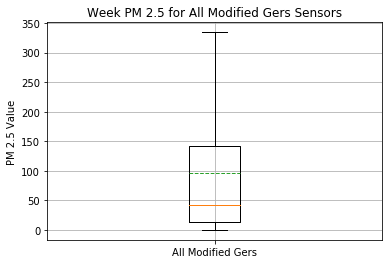

In [5]:
labels = ['All Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in modified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = modified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:1000])

all_modified_gers = [modified_gers_data.pm2_5.dropna()]
print('{} list size: {}'.format(labels[0], len(data.pm2_5)))
results = plt.boxplot(all_modified_gers, showfliers=False, labels=labels, showmeans=True, meanline=True)

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])


All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'ID', 'IL', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object')
Mon list size: 548231
Tue list size: 565067
Wed list size: 581728
Thu list size: 580710
Fri list size: 600987
Sat list size: 591662
Sun list size: 577060
total for all days: 4045445

whiskers:  [0.0, 306.9340206185567, 0.0, 327.2783505154639, 0.0, 341.43092783505153, 0.0, 339.6618556701031, 0.0, 349.3917525773196, 0.0, 322.8556701030928, 0.0, 338.7773195876289]
caps:  [0.0, 306.9340206185567, 0.0, 327.2783505154639, 0.0, 341.43092783505153, 0.0, 339.6618556701031, 0.0, 349.3917525773196, 0.0, 322.8556701030928, 0.0, 338.7773195876289]
boxes:  [13.268041237113401, 13.268041237113401, 12.383505154639176, 15.037113402061856, 15

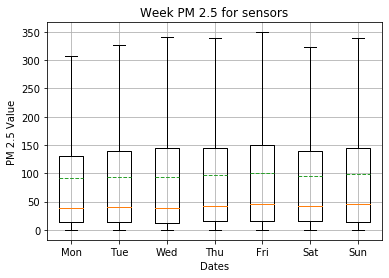

In [6]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in modified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = modified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = modified_gers_data[(modified_gers_data.index.day_name() == 'Monday')]['pm2_5'].dropna()
tuesday = modified_gers_data[modified_gers_data.index.day_name() == 'Tuesday']['pm2_5'].dropna()
wednesday = modified_gers_data[modified_gers_data.index.day_name() == 'Wednesday']['pm2_5'].dropna()
thursday = modified_gers_data[modified_gers_data.index.day_name() == 'Thursday']['pm2_5'].dropna()
friday = modified_gers_data[modified_gers_data.index.day_name() == 'Friday']['pm2_5'].dropna()
saturday = modified_gers_data[modified_gers_data.index.day_name() == 'Saturday']['pm2_5'].dropna()
sunday = modified_gers_data[modified_gers_data.index.day_name() == 'Sunday']['pm2_5'].dropna()
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)

i = 0
cumulative = 0
for day in all_days:
    print('{} list size: {}'.format(labels[i], len(day)))
    cumulative += len(day)
    i+= 1
print('total for all days: {}'.format(cumulative))
print()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])


All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'ID', 'IL', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object')
Monday - AK list size: 14878
Monday - AK list size of data above 1000: 0
Monday - AL list size: 32111
Monday - AL list size of data above 1000: 0
Monday - AR list size: 20509
Monday - AR list size of data above 1000: 0
Monday - AZ list size: 34237
Monday - AZ list size of data above 1000: 0
Monday - CA list size: 23485
Monday - CA list size of data above 1000: 0
Monday - CO list size: 17496
Monday - CO list size of data above 1000: 0
Monday - CT list size: 11207
Monday - CT list size of data above 1000: 0
Monday - DE list size: 36164
Monday - DE list size of data above 1000: 0
Monday - GA list size: 19185
Monday - GA list si

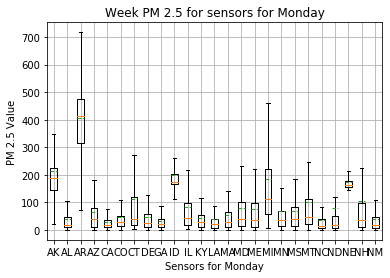

Tuesday - AK list size: 16163
Tuesday - AK list size of data above 1000: 0
Tuesday - AL list size: 33180
Tuesday - AL list size of data above 1000: 0
Tuesday - AR list size: 20300
Tuesday - AR list size of data above 1000: 0
Tuesday - AZ list size: 34953
Tuesday - AZ list size of data above 1000: 0
Tuesday - CA list size: 24461
Tuesday - CA list size of data above 1000: 0
Tuesday - CO list size: 17751
Tuesday - CO list size of data above 1000: 0
Tuesday - CT list size: 12498
Tuesday - CT list size of data above 1000: 0
Tuesday - DE list size: 37442
Tuesday - DE list size of data above 1000: 0
Tuesday - GA list size: 17980
Tuesday - GA list size of data above 1000: 0
Tuesday - ID list size: 29749
Tuesday - ID list size of data above 1000: 0
Tuesday - IL list size: 23126
Tuesday - IL list size of data above 1000: 0
Tuesday - KY list size: 11756
Tuesday - KY list size of data above 1000: 0
Tuesday - LA list size: 15996
Tuesday - LA list size of data above 1000: 0
Tuesday - MA list size: 3

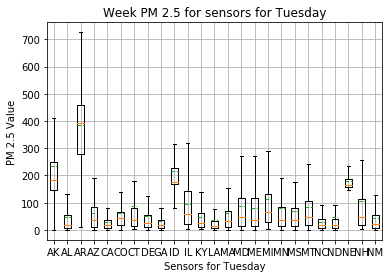

Wednesday - AK list size: 19740
Wednesday - AK list size of data above 1000: 0
Wednesday - AL list size: 33431
Wednesday - AL list size of data above 1000: 0
Wednesday - AR list size: 22608
Wednesday - AR list size of data above 1000: 0
Wednesday - AZ list size: 35007
Wednesday - AZ list size of data above 1000: 0
Wednesday - CA list size: 24474
Wednesday - CA list size of data above 1000: 0
Wednesday - CO list size: 18697
Wednesday - CO list size of data above 1000: 0
Wednesday - CT list size: 13071
Wednesday - CT list size of data above 1000: 0
Wednesday - DE list size: 37967
Wednesday - DE list size of data above 1000: 0
Wednesday - GA list size: 17278
Wednesday - GA list size of data above 1000: 0
Wednesday - ID list size: 31700
Wednesday - ID list size of data above 1000: 0
Wednesday - IL list size: 23521
Wednesday - IL list size of data above 1000: 0
Wednesday - KY list size: 11110
Wednesday - KY list size of data above 1000: 0
Wednesday - LA list size: 14889
Wednesday - LA list 

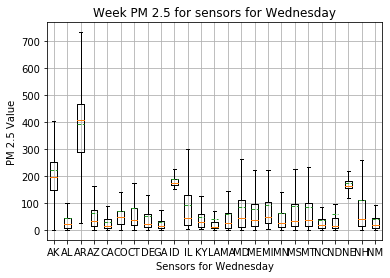

Thursday - AK list size: 20115
Thursday - AK list size of data above 1000: 0
Thursday - AL list size: 34390
Thursday - AL list size of data above 1000: 0
Thursday - AR list size: 25263
Thursday - AR list size of data above 1000: 0
Thursday - AZ list size: 35500
Thursday - AZ list size of data above 1000: 0
Thursday - CA list size: 24479
Thursday - CA list size of data above 1000: 0
Thursday - CO list size: 20994
Thursday - CO list size of data above 1000: 0
Thursday - CT list size: 9821
Thursday - CT list size of data above 1000: 0
Thursday - DE list size: 38567
Thursday - DE list size of data above 1000: 0
Thursday - GA list size: 15597
Thursday - GA list size of data above 1000: 0
Thursday - ID list size: 29660
Thursday - ID list size of data above 1000: 0
Thursday - IL list size: 24406
Thursday - IL list size of data above 1000: 0
Thursday - KY list size: 12115
Thursday - KY list size of data above 1000: 0
Thursday - LA list size: 16096
Thursday - LA list size of data above 1000: 0


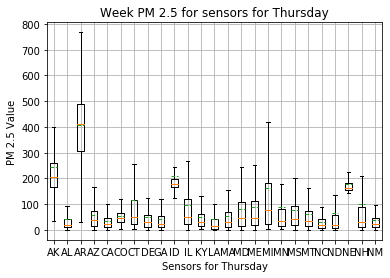

Friday - AK list size: 19589
Friday - AK list size of data above 1000: 0
Friday - AL list size: 35983
Friday - AL list size of data above 1000: 0
Friday - AR list size: 25908
Friday - AR list size of data above 1000: 0
Friday - AZ list size: 37010
Friday - AZ list size of data above 1000: 0
Friday - CA list size: 24470
Friday - CA list size of data above 1000: 0
Friday - CO list size: 20617
Friday - CO list size of data above 1000: 0
Friday - CT list size: 11229
Friday - CT list size of data above 1000: 0
Friday - DE list size: 38756
Friday - DE list size of data above 1000: 0
Friday - GA list size: 16738
Friday - GA list size of data above 1000: 0
Friday - ID list size: 30250
Friday - ID list size of data above 1000: 0
Friday - IL list size: 24583
Friday - IL list size of data above 1000: 0
Friday - KY list size: 12743
Friday - KY list size of data above 1000: 0
Friday - LA list size: 17416
Friday - LA list size of data above 1000: 0
Friday - MA list size: 34043
Friday - MA list size 

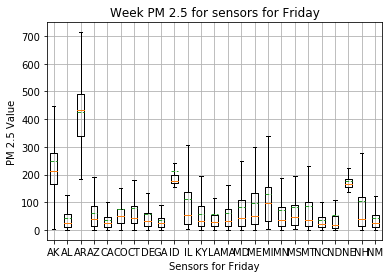

Saturday - AK list size: 19270
Saturday - AK list size of data above 1000: 0
Saturday - AL list size: 35698
Saturday - AL list size of data above 1000: 0
Saturday - AR list size: 23302
Saturday - AR list size of data above 1000: 0
Saturday - AZ list size: 37364
Saturday - AZ list size of data above 1000: 0
Saturday - CA list size: 24477
Saturday - CA list size of data above 1000: 0
Saturday - CO list size: 20643
Saturday - CO list size of data above 1000: 0
Saturday - CT list size: 11109
Saturday - CT list size of data above 1000: 0
Saturday - DE list size: 38682
Saturday - DE list size of data above 1000: 0
Saturday - GA list size: 18719
Saturday - GA list size of data above 1000: 0
Saturday - ID list size: 30549
Saturday - ID list size of data above 1000: 0
Saturday - IL list size: 24888
Saturday - IL list size of data above 1000: 0
Saturday - KY list size: 13383
Saturday - KY list size of data above 1000: 0
Saturday - LA list size: 15866
Saturday - LA list size of data above 1000: 0

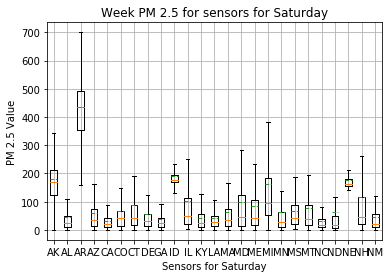

Sunday - AK list size: 17068
Sunday - AK list size of data above 1000: 0
Sunday - AL list size: 33300
Sunday - AL list size of data above 1000: 0
Sunday - AR list size: 21859
Sunday - AR list size of data above 1000: 0
Sunday - AZ list size: 37285
Sunday - AZ list size of data above 1000: 0
Sunday - CA list size: 24473
Sunday - CA list size of data above 1000: 0
Sunday - CO list size: 19839
Sunday - CO list size of data above 1000: 0
Sunday - CT list size: 11633
Sunday - CT list size of data above 1000: 0
Sunday - DE list size: 38806
Sunday - DE list size of data above 1000: 0
Sunday - GA list size: 19170
Sunday - GA list size of data above 1000: 0
Sunday - ID list size: 28834
Sunday - ID list size of data above 1000: 0
Sunday - IL list size: 24769
Sunday - IL list size of data above 1000: 0
Sunday - KY list size: 12823
Sunday - KY list size of data above 1000: 0
Sunday - LA list size: 16086
Sunday - LA list size of data above 1000: 0
Sunday - MA list size: 33116
Sunday - MA list size 

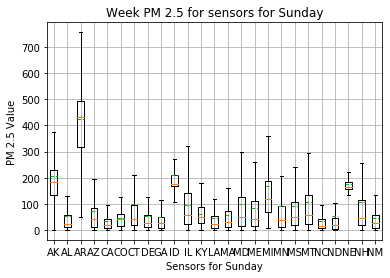

In [7]:
# modified_gers each sensors - This is the working boxplot for modified_gers only Mongolia deployed sensors

plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

all_sensors_names = []
for name, sensor_data in modified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = modified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = modified_gers_data[modified_gers_data.index.day_name() == day]
    # temp = temp.groupby("name")
    cumulative = 0
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].dropna().to_numpy().tolist())
        cumulative += len(sensor_data)
        print('{} - {} list size: {}'.format(day, name,  len(sensor_data)))
        print('{} - {} list size of data above 1000: {}'.format(day, name,  len(sensor_data[sensor_data.pm2_5 > 1000])))
    print ('{} total: {}'.format(day, cumulative))    
    print()
    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()
    